In [1]:
from imshowtools import cvshow, imshow
import numpy as np
import cv2
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

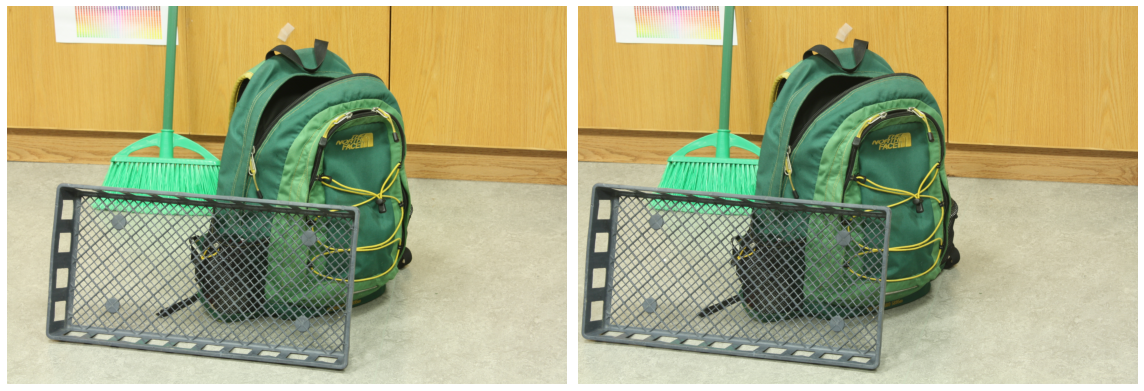

In [2]:
# Load In Image data and set camaera calibration

#Camera matrices for the rectified views, in the form [f 0 cx; 0 f cy; 0 0 1]
## f: focal lenght, cx cy: principal point
calib = np.array([7190.247, 0, 1938.523, 0, 7190.247, 913.94, 0, 0, 1]).reshape((3,3)).astype(np.float32)

#Load pair of images side by side
image_1 = cv2.imread('./Backpack-imperfect/im0.png')
image_2 = cv2.imread('./Backpack-imperfect/im1.png')

#Display png from above in an OpenCv window, also changes RGB format to BGR to allow OpenCV to read it
cvshow(image_1, image_2, size=(16,16))

In [3]:
#Allows use of SIFT features from OpenCV with the keyword sift
sift = cv2.SIFT_create()

#Detect keypoints and compute associated descriptors
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

print(f"# of keypoints in image_1: {len(keypoints_1)}")
print(f"# of keypoints in image_2: {len(keypoints_2)}")
print(f"Shape of descriptors: {[descriptors_1.shape, descriptors_2.shape]}")

# of keypoints in image_1: 13970
# of keypoints in image_2: 14371
Shape of descriptors: [(13970, 128), (14371, 128)]


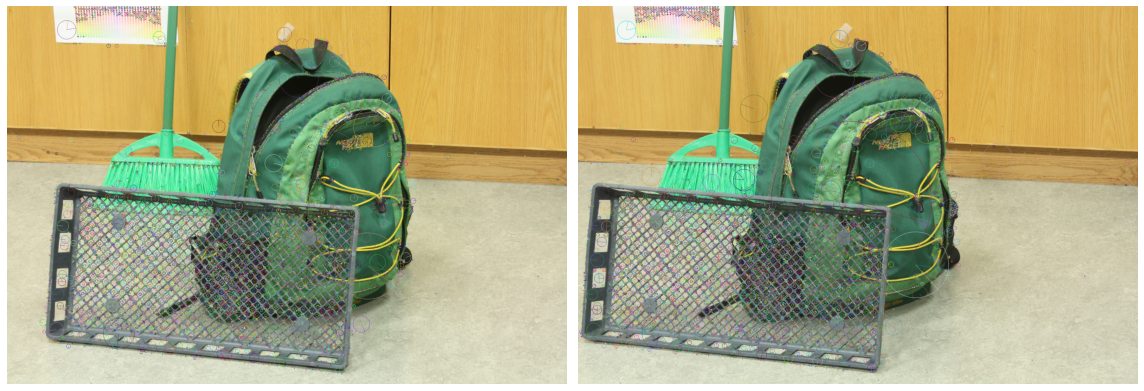

In [4]:
#Draw the computed keypoints  
image_1_kp = cv2.drawKeypoints(image_1, keypoints_1, image_1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_2_kp = cv2.drawKeypoints(image_2, keypoints_2, image_2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Display images with computed keypoints and descriptors 
cvshow(image_1_kp, image_2_kp, size=(16, 16))

In [9]:
def draw_keypoints(image, keypoints):
    ''' draw the keypoints returned from OpenCV's detect function
    on the image
    '''
    
    #Alter visibility of lines if needed
    thickness = 10
    alpha = 0.6
    
    #Draw circle on duplicate image overlaying over the original with transparency as
    #OpenCV can not draw transparent circles on images
    overlay = image.copy()
    
    for keypoint in keypoints:
        
        #Give values for a circle(keypoints)
        ## x y: centre of circle, radius, theta: angle the radius line is tilted
        x = int(keypoint.pt[0]) 
        y = int(keypoint.pt[1]) 
        radius = keypoint.size/2 
        theta = keypoint.angle * (np.pi/180) 
        size = radius
        
        #find the endpoint (x2, y2)
        x2 = x +int(radius * np.cos(theta)) ## STEP 5: assign x2 
        y2 = y +int(radius * np.sin(theta)) ## STEP 6: assign y2
        
        #draw circles and lines using a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.circle(overlay, (x,y), int(size), color, thickness)
        cv2.line(overlay, (x, y), (x2, y2), color, thickness)
        
    #overlay with alpha on original images, the images with circles on it
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    return image

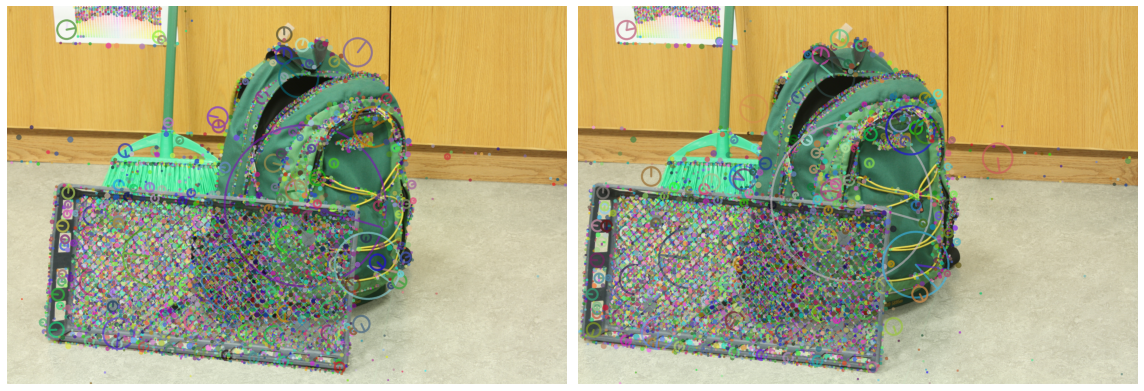

In [11]:
#draw and display keypoints with altered keypoint visibility 
image_1_kp = draw_keypoints(image_1.copy(), keypoints_1)
image_2_kp = draw_keypoints(image_2.copy(), keypoints_2)
cvshow(image_1_kp, image_2_kp, size=(16, 16))

In [16]:
#Approximate Nearest Neighbour alogorithm 
#Builds data structure KD-tree
def get_matches_flann(descriptors_1, descriptors_2):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    #Create dictionary of index parameters and search parameters 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    #Need only good matches so knnMatch to find the best matches for each descriptor for query set
    matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)
    
    
    #print(matches)
    return matches

In [18]:
#Eliminate all bad matches using Lowes ratio test 
good_matches = []
matches = get_matches_flann(descriptors_1, descriptors_2)


for m,n in (matches):
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

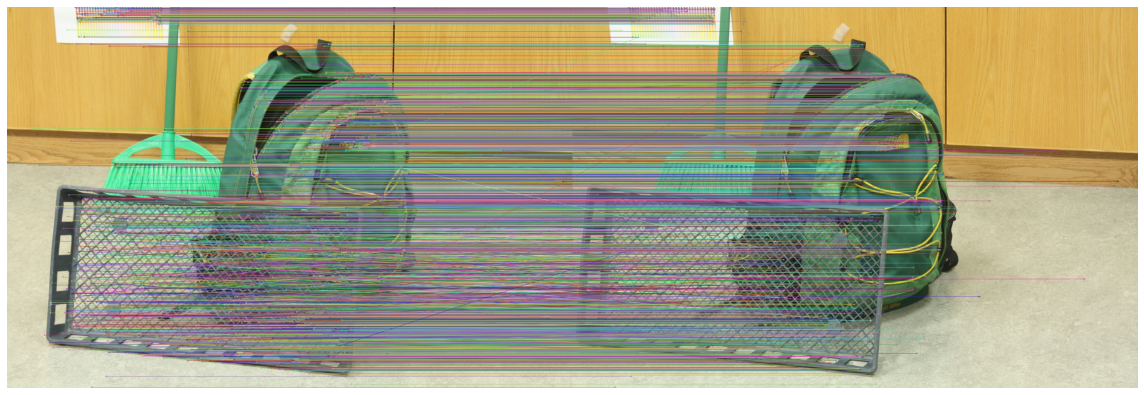

In [19]:
#Draw matches from both images from keypoints
image_matches = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, good_matches, None, flags=2)
cvshow(image_matches, size=(16, 16))

In [20]:
#Build points matched
points_matched_1 = np.array([keypoints_1[m.queryIdx].pt for m in good_matches], dtype=int)
points_matched_2 = np.array([keypoints_2[m.trainIdx].pt for m in good_matches], dtype=int)

In [21]:
def eigth_point_algorithm(x1, x2):
    """
    x1: param contains the 8-points from the left image
    x2: param contains the 8 corresponding points in the right image
    
    """
    arr = []
    
    #Split the selected points into variables
    #Point x1
    
    xP1 = x1[:,0]
    yP1 = x1[:,1]
    
    #Point x2
    xP2 = x2[:,0]
    yP2 = x2[:,1]
   
    #Build first line of matrix
    arr = np.array([xP1*xP2, yP1*xP2, xP2, xP1*yP2, yP1*yP2, yP2, xP1, yP1, np.ones(x1.shape[0])])
    
    #Stack matrices
    A = np.transpose(np.vstack(arr))
    
    
    ## TODO: Add the necessary code here to compute the A matrix of 
    ## constraints for the 8 point algorithm
    ## Be careful to get the ordering of the left and
    ## right points correct when constructing the constraint rows. 
    ## Review the online lecture, notes, etc. if
    ## you have any difficulties
    # The code below will take your A matrix and compute
    # the corresponding Essential matrix
    U,S,V = np.linalg.svd(A)
    #print(U,S,V)
    E = V[-1].reshape(3,3)
    #print(E)
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(E)
    S[2] = 0
    E = np.dot(U, np.dot(np.diag(S), V))
    
    # Keep the last element 1, 
    # divide the whole matrix by that element
    return E / E[2,2]

In [22]:
def eigth_point_algorithm_normalized(x1, x2):
    """
    First proposed by Richard Hartley 1997 in "In Defence of the 8-point Algorithm"
    For neat equations, see equation (10) in Chojnacki et al 2003
    Revisiting Hartley’s Normalized Eight-Point Algorithm
    https://cs.adelaide.edu.au/~wojtek/papers/pami-nals2.pdf
    """
    
    # compute T1
    x1 = x1 / x1[:, 2][:, None]
    mean_1 = np.mean(x1[:, :2], axis=0)
    s1 = np.sqrt(2) / np.std(x1[:, :2])
    T1 = np.array([[s1,   0,  -s1*mean_1[0]],
                   [ 0,  s1,  -s1*mean_1[1]],
                   [ 0,   0,             1]])

    
    # compute T2
    x2 = x2 / x2[:, 2][:, None]
    mean_2 = np.mean(x2[:, :2], axis=0)
    s2 = np.sqrt(2) / np.std(x2[:, :2])
    T2 = np.array([[s2,   0,  -s2*mean_2[0]],
                   [ 0,  s2,  -s2*mean_2[1]],
                   [ 0,   0,             1]])
    
    # normalize x1 and x2
    # Shapes: T(3, 3), x(n, 3)
    # After Transpose: T(3, 3), x(3, n)
    # Result = (3, n)
    # Result Transpose: (n, 3)
    x1 = np.dot(T1, x1.T).T
    x2 = np.dot(T2, x2.T).T
    
    # Find E using eigth_point_algorithm
    E = eigth_point_algorithm(x1, x2)
    
    # unnormalized E = T2' (E T1)
    E = np.dot(T2.T, np.dot(E, T1))
    
    # Keep the last element 1, 
    # divide the whole matrix by that element
    return E / E[2,2]

In [23]:
def point_line_distance(line, point):
    a, b, c = line
    u, v = point
    return abs((a*u + b*v + c) / np.sqrt(a ** 2 + b ** 2))

In [24]:
def find_inliers(F, keypoints_1, keypoints_2, threshold=10):
    mask = []
    
    ## The zip function here takes two list and creates a new iteratable zip object
    ## where on each iteration keypoint_1 and keypoint_2 will be two keypoints
    for keypoint_1, keypoint_2 in zip(keypoints_1, keypoints_2):
        # Compute the parameters of the epilines in each image
        ## TODO: ADD CODE HERE TO COMPUTE line_1 and line_2 ##
        ##       EACH OF WHICH SHOULD BE A VECTOR OF 3 LINE ##
        ##      PARAMETERS   
        
        u = v = w = u1 = v1 = w1 = 0
        x, y, x1, y1 = keypoint_1[0], keypoint_1[1], keypoint_2[0], keypoint_2[1]
        
        u = ((F[0][0]*x)+(F[0][1]*y)+(F[0][2]))
        v = ((F[1][0]*x)+(F[1][1]*y)+(F[1][2]))
        w = ((F[2][0]*x)+(F[2][1]*y)+(F[2][2]))
        
        u1 = ((F.T[0][0]*x1)+(F.T[0][1]*y1)+(F.T[0][2]))
        v1 = ((F.T[1][0]*x1)+(F.T[1][1]*y1)+(F.T[1][2]))
        w1 = ((F.T[2][0]*x1)+(F.T[2][1]*y1)+(F.T[2][2]))
    
        line_1 = np.array([u,v,w])
        line_2 = np.array([u1,v1,w1])
        
        
        # Compute the error between the point and the epiline (i.e using point_line_distance)
        ## TODO: ADD CODE HERE TO COMPUTE THE DISTANCE BETWEEN ##
        ## EACH LINE AND THE CORRESPONDING POINT FROM THE OTHER##
        ## IMAGE. YOU SHOULD STORE THE VALUES IN TWO VARIABLES ##
        ## error_1 AND error_2 RESPECTIVELY                    ##
        error_1 = point_line_distance(line_1, keypoint_1)
        error_2 = point_line_distance(line_2, keypoint_2)
        
        error = np.sqrt(error_1**2 + error_2**2)
        
        passed = True if error < threshold else False
        mask.append([passed])
    return np.array(mask)

In [25]:
def get_F(K_inv, E):
    return np.dot(K_inv.T, np.dot(E, K_inv))

In [26]:
## STEP 4: FIRST COMPLETE STEPS 1-3 BELOW. NOW REVIEW THE RANSAC   ##
## PSEUDO CODE ALGORITHM IN THE CORRESPONDING SECTION ABOVE. ADD   ##
## COMMENTS TO THE APPROPRIATE LINES OF THIS FUNCTION TO INDENTIFY ##
## WHICH PARTS OF THE PSEUDO CODE ALGORITHM CORRESPOND TO THE      ##
## LINES OF CODE IN THE FUNCTION                                   ##

def find_essential_matrix(keypoints_1, keypoints_2, K, ransac_iterations=100):
    num_inliers_list = []
    inliers_mask_list = []
    E_list = []
    K_inv = np.linalg.inv(K)
    # Shape (n, 2) -> (n, 3)
    ## STEP 1: ADD CODE HERE TO CONVERT EACH SET OF KEYPOINTS TO HOMOGENEOUS FORM  ##
    ## NOTE YOU SHOULD STORE THEM IN A SEPARATE VARIABLE NAME i.e. DON'T OVERWRITE ##
    ## keypoints_1 and keypoints_2   
    new_points_1 = np.reshape(cv2.convertPointsToHomogeneous(keypoints_1), (-1, 3))
    new_points_2 = np.reshape(cv2.convertPointsToHomogeneous(keypoints_2), (-1, 3))
    # Normalize using K_inv to get normalized image coordinates
    ## STEP 2: ADD CODE HERE TO REPROJECT EACH SET OF HOMOGENEOUS KEYPOINTS ##
    ## TO NORMALISED COORDINATES.                 
    #print(form_points_2)
    normalised_points_1 = np.array([K_inv.dot(x) for x in new_points_1])
    normalised_points_2 = np.array([K_inv.dot(x) for x in new_points_2])    
    
    # This for loop runs for ransac_iterations number of iterations
    # Wrapping range(ransac_iterations) in a tqdm object should result
    # in a progress bar being displayed as RANSAC progresses 
    for _ in tqdm(range(ransac_iterations)):
        
        ## STEP 3: ADD CODE HERE TO SELECT 8 CORRESPONDENCES AT RANDOM FROM ##
        ## THE NORMALISED COORDINATE VERSIONS OF THE KEYPOINTS YOU SHOULD   ##
        ## STORE THE SELECTED CORRESPONDENCES SUCH THAT THE POINTS FROM     ##
        ## THE FIRST IMAGE ARE IN keypoints_1_selected AND THE POINTS FROM  ##
        ## IMAGE TWO ARE STORED IN keypoints_2_selected                     ##
        ## HINT: FOR SELECTING ELEMENTS AT RANDOM YOU SHOULD TAKE A LOOK AT ##
        ## np.random.choice                                                 ##
        
        idx = np.random.choice(np.arange(len(normalised_points_1)), 8, replace=False)
        
        keypoints_1_selected = normalised_points_1[idx]
        keypoints_2_selected = normalised_points_2[idx]

       # print(keypoints_2_selected)
        
        E = eigth_point_algorithm_normalized(keypoints_1_selected, keypoints_2_selected)
        F = get_F(K_inv, E)
        inliers_mask = find_inliers(F, keypoints_1, keypoints_2)
        #print(len(inliers_mask))
        E_list.append(E)
        inliers_mask_list.append(inliers_mask)
        num_inliers_list.append(np.sum(inliers_mask))
    best_index = num_inliers_list.index(max(num_inliers_list))
    best_E = E_list[best_index]
    best_E_inliers_mask = inliers_mask_list[best_index]
    return best_E, best_E_inliers_mask, 

In [27]:
E, mask = find_essential_matrix(points_matched_1, points_matched_2, calib)
E, sum(mask)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([[ 2.55124013e+00, -7.52329194e+02, -4.87686078e+00],
        [ 6.75216647e+02,  7.33474563e+01,  1.43756864e+03],
        [ 9.77670303e+00, -1.44559276e+03,  1.00000000e+00]]),
 array([1850]))

In [28]:
inlier_indices = mask.ravel() == 1

In [29]:
points_inlier_1 = points_matched_1[inlier_indices]
points_inlier_2 = points_matched_2[inlier_indices]

points_inlier_1.shape, points_inlier_2.shape

((1850, 2), (1850, 2))

In [30]:
def get_epipolar_lines_on_image_1(points_inlier_2, F): 
    # Calls the function to get epipoler lines on image one created from inliers points found on image 2. 
    # The fundamental matrix is also taken into this function
    
    points_inlier_2_3dim = np.pad(points_inlier_2, ((0, 0), (0, 1)), mode='constant', constant_values=1)
    # Pads the inlier points to create a 3 dimensional co-ordinate by adding a one as the third variable
    # (x,y) -> (x,y,1)
   
    return np.dot(points_inlier_2_3dim, F) 
    # Returns the dot product of the 3 dimensional inlier points and the fundamental matrix
    # This computes the epipolar lines on Image 1

def get_epipolar_lines_on_image_2(points_inlier_1, F):
    # This funciton works the same as the obve except uses inlier points found on Image 1 
    # To find the corresponding Epipolar lines on Image 2
    points_inlier_1_3dim = np.pad(points_inlier_1, ((0, 0), (0, 1)), mode='constant', constant_values=1)
    return np.dot(F, points_inlier_1_3dim.T).T
    # differing to the above function we transpose to arrange the matrix in the appropriate order for multiplication
    # and for returning 

In [31]:
F = get_F(np.linalg.inv(calib),E)
# Computes the fundamental matrix
epipolar_lines_1 = get_epipolar_lines_on_image_1(points_inlier_2, F)
epipolar_lines_2 = get_epipolar_lines_on_image_2(points_inlier_1, F)
# The above two lines compute the epipoler lines for Image 1 and Image 2
# And saves the result in variables epipolar_lines_1 and epipolar_lines_2 respectivley

In [32]:
def drawlines(image_1, image_2, lines, points_1, points_2):
    """
    Draw the epipolar lines on image_1 for the points in image_2
    :param image_1: Image on which epipolar lines should be drawn
    :param image_2: Image on which keypoints are computed
    :param lines: Epipolar lines of shape (<>, 3)
    :param points_1: Keypoints on image_1
    :param points_2: Keypoints on image_2
    :return: (image_1, image_2) where image_2 has keypoints and 
        image_1 has corresponding epipolar lines on it along with image_1 keypoints 
    """
    r, c = image_1.shape[:2]
    image_1_overlay = image_1.copy()
    image_2_overlay = image_2.copy()
    alpha_1 = 0.5
    alpha_2 = 0.7
    
    for r, point_1, point_2 in zip(lines, points_1, points_2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(image_1_overlay, (x0, y0), (x1, y1), color, 3)
        cv2.circle(image_1_overlay, tuple(point_1), 15, color, 3)
        cv2.circle(image_2_overlay, tuple(point_2), 15, color, 3)
    
    image_1 = cv2.addWeighted(image_1_overlay, alpha_1, image_1, 1 - alpha_1, 0)
    image_2 = cv2.addWeighted(image_2_overlay, alpha_2, image_2, 1 - alpha_2, 0)
    return image_1, image_2

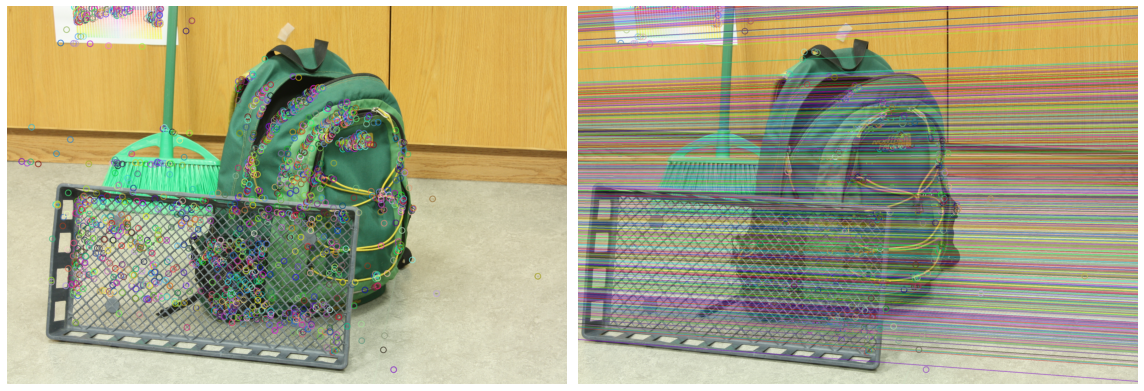

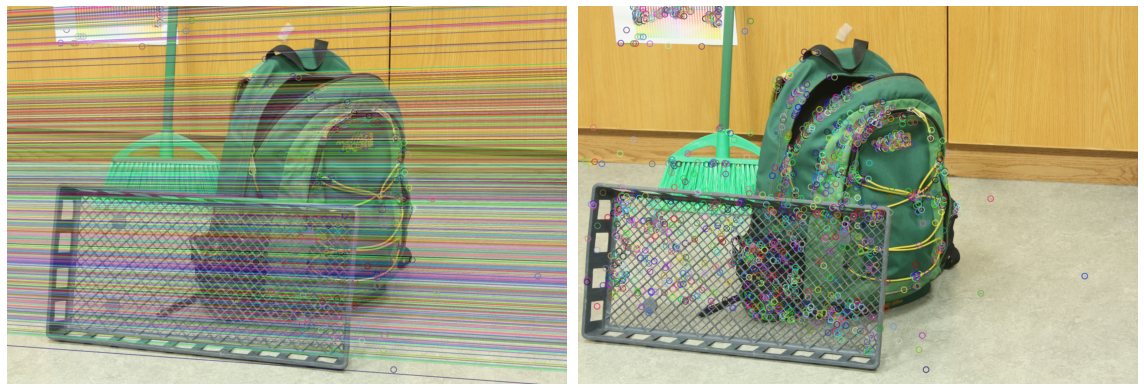

In [33]:
image_1_lines, image_2_points = drawlines(np.copy(image_1), np.copy(image_2), epipolar_lines_1, points_inlier_1, points_inlier_2)
image_2_lines, image_1_points = drawlines(np.copy(image_2), np.copy(image_1), epipolar_lines_2, points_inlier_2, points_inlier_1)

cvshow(image_1_points, image_2_lines, size=(16, 16))
cvshow(image_1_lines, image_2_points, size=(16, 16))

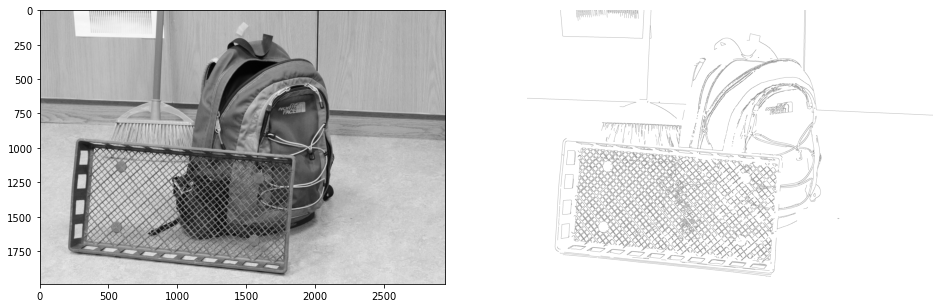

In [34]:
img = cv2.imread('./Backpack-imperfect/im0.png',0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
sketch = cv2.bitwise_not(edges)
imshow(sketch, cmap='gray', size=(16, 16))

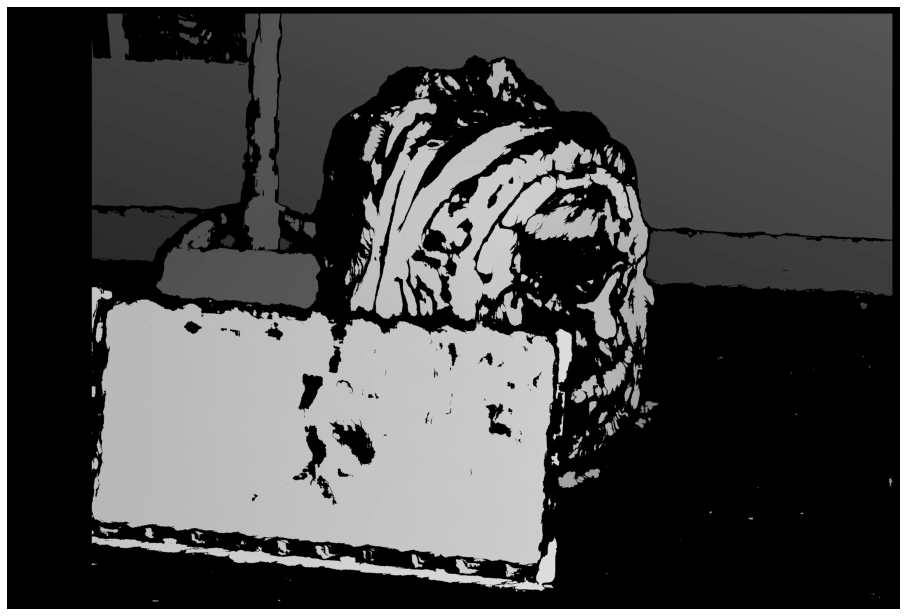

In [35]:
image_1_bw = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
image_2_bw = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
stereo = cv2.StereoBM_create(numDisparities=256, blockSize=51)
disparity = stereo.compute(image_1_bw, image_2_bw)
imshow(disparity, cmap='gray', size=(16, 16))

In [36]:
print(f"Before: {np.max(disparity), np.min(disparity)}")
corrected_disparity = disparity / 16
print(f"After: {np.max(corrected_disparity), np.min(corrected_disparity)}")

Before: (3879, -16)
After: (242.4375, -1.0)


In [37]:
zero_indices = np.where(corrected_disparity==0)
corrected_disparity[zero_indices] = 1e-3

In [38]:
baseline = 193.001

In [39]:
focal_length = calib[0,0]
depth = (baseline * focal_length) / (corrected_disparity)
depth = depth / 1000   # to m

In [40]:
small_size = (150, 75)
depth_small = cv2.resize(depth, small_size)
image_1_small = cv2.resize(image_1[:, :, ::-1], small_size)

In [41]:
row, col = np.indices(depth_small.shape)
row.shape, col.shape, depth_small.shape

((75, 150), (75, 150), (75, 150))

In [42]:
remove_background = True
show_unmapped_pixels_at_depth = 40

In [43]:
c = image_1_small.reshape(-1, 3)/255
c = np.pad(c, ((0,0), (0,1)), mode='constant', constant_values=1)

# for depth
d = depth_small.flatten()

if remove_background:
    # to remove background, we should hide the pixels for which we didn't have disparity
    # let's correct that and recalculate depth_small and then 
    # set color of those points to (0, 0, 0, 0) so they become invisible
    depth_corrected = depth.copy()
    depth_corrected[np.where(depth_corrected==-focal_length*baseline/1000)] = -1
    depth_small = cv2.resize(depth_corrected, small_size)
    d = depth_small.flatten()
    c[np.where(d==-1)] = 0
    
else:
    d[np.where(d==-1)] = show_unmapped_pixels_at_depth

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

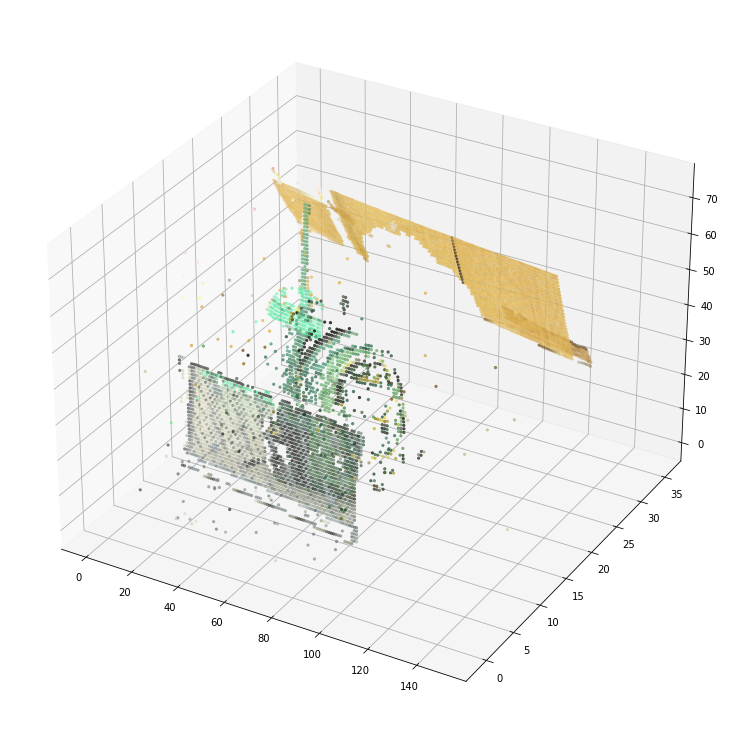

In [44]:
%matplotlib widget
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig)
ax.scatter(col[::-1], d, row[::-1], c=c, marker='.')
plt.show()